In [1]:
import pathlib

import h5py
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_selection
import sklearn.ensemble
import sklearn.impute
import sklearn.linear_model
import sklearn.svm
import rich
import rich.table

import lib_utils


In [2]:
data = lib_utils.load_split_data("data/original.shuffled_and_split.h5")

In [3]:
nan_counts_features = np.isnan(data["train"]["features"]).sum(axis=0)

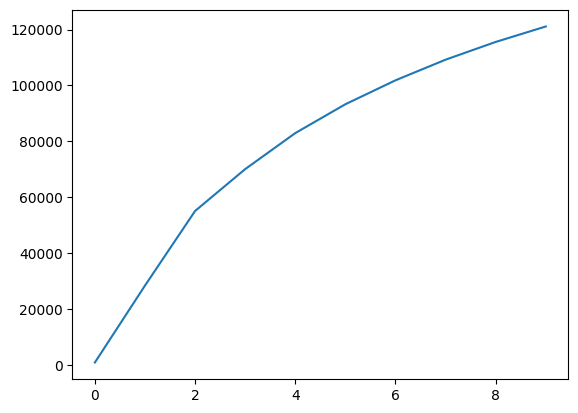

In [4]:
plt.plot([(nan_counts_features <= i).sum() for i in range(10)])

In [5]:
nan_counts_ppl = np.isnan(data["train"]["features"]).sum(axis=1)

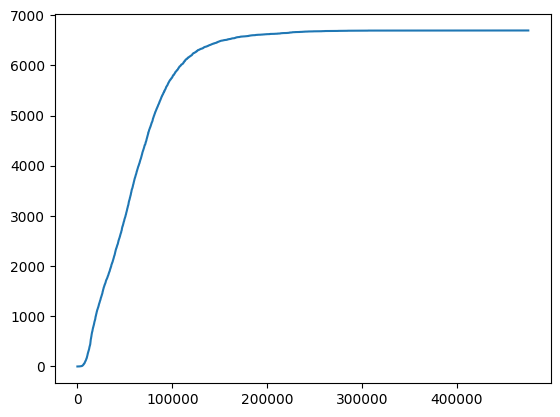

In [6]:
plt.plot([(nan_counts_ppl <= i).sum() for i in range(nan_counts_ppl.max())])

In [7]:
fake_data = np.array([[1., 2., .0], [2, 4, .1], [3, 5, .2], [0., 1., .3],]).T

print(np.nanmean(fake_data, axis=0).shape)
fake_data -= np.nanmean(fake_data, axis=0)
fake_data /= np.std(fake_data, axis=0)

print(fake_data)
print(fake_data.T.shape)
np.correlate(np.arange(10) - np.arange(10).mean(), np.arange(10) - np.arange(10).mean())

(4,)
[[ 0.         -0.02093352  0.13545709 -1.03422447]
 [ 1.22474487  1.23507745  1.15138528  1.35244738]
 [-1.22474487 -1.21414393 -1.28684238 -0.31822291]]
(4, 3)


array([82.5])

In [8]:
data = lib_utils.load_split_data("data/original.shuffled_and_split.h5")

In [19]:
# Nan removal
subset_mask = (np.isnan(data["train"]["features"]).sum(axis=0) < 10)
subset_indices = np.arange(data["train"]["features"].shape[1])[subset_mask]
print(f"{subset_mask.shape = }")
print(f"{subset_indices.shape = }")

subset_data = {
    split: {
        information_type: information_data[:, subset_mask] 
        if information_type == "features" else information_data
        for information_type, information_data in split_values.items()
    } for split, split_values in data.items()
}
del data
print(f"{subset_data['train']['features'].shape = }")

subset_mask.shape = (485512,)
subset_indices.shape = (121099,)
subset_data['train']['features'].shape = (6699, 121099)


In [20]:
# Imputation
imputer = sklearn.impute.SimpleImputer(strategy="mean")
print("Training")
imputer.fit(subset_data["train"]["features"])

print("Transforming")

imputed_subset_data = {
    split: {
        information_type: imputer.transform(information_data)
        if information_type == "features" else information_data
        for information_type, information_data in split_values.items()
    } for split, split_values in subset_data.items()
}
del subset_data
print(f"{imputed_subset_data['train']['features'].shape = }")


Training
Transforming
imputed_subset_data['train']['features'].shape = (6699, 121099)


In [21]:
# Normalization
mean = np.nanmean(imputed_subset_data["train"]["features"], axis=0, keepdims=True)
print(mean.shape)
std = np.nanstd(imputed_subset_data["train"]["features"], axis=0, keepdims=True)
print(std.shape)

normalized_imputed_subset_data = {
    split: {
        information_type: (information_data - mean) / std
        if information_type == "features" else information_data
        for information_type, information_data in split_values.items()
    } for split, split_values in imputed_subset_data.items()
}
del imputed_subset_data
print(normalized_imputed_subset_data["train"]["features"].shape)

(1, 121099)
(1, 121099)
(6699, 121099)


In [36]:

def prep_data(n_features, normalized_imputed_subset_data):
    
    feature_selector = sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.f_regression, 
        k=n_features
    ).fit(
        normalized_imputed_subset_data["train"]["features"], 
        normalized_imputed_subset_data["train"]["age"],
    )

    feature_selected_data = {
        split: {
            information_type: feature_selector.transform(information_data)
            if information_type == "features" else information_data
            for information_type, information_data in split_values.items()
        } for split, split_values in normalized_imputed_subset_data.items()
    }
    return feature_selected_data


def evaluate(*, regressor, feature_selected_data, n_features, **kwargs):
    preds = regressor.predict(feature_selected_data["validation"]["features"])
    mae = sklearn.metrics.mean_absolute_error(preds, feature_selected_data['validation']['age'])
    mse = sklearn.metrics.mean_squared_error(preds, feature_selected_data['validation']['age'])
    medae = sklearn.metrics.median_absolute_error(preds, feature_selected_data['validation']['age'])

    r2 = regressor.score(
        feature_selected_data['validation']['features'], 
        feature_selected_data['validation']['age'],
    )

    print(
        f"### Metrics ### " + 
        f"{r2 = :.2f} # " +  
        f"{medae = :0.2f} # " +
        f"{mae = :.2f} # " +
        f"{mse = :.2f}" + 
        f"\n### HyperParams ### {n_features = } # " +
        " # ".join(f"{k} = {v}" for k, v in kwargs.items())
    )

def train_predict_evaluate(feature_selected_data, n_features, alpha, l1_ratio):
    if alpha == 0:
        regressor = sklearn.linear_model.LinearRegression(
        )
    elif l1_ratio == 0:
        regressor = sklearn.linear_model.Ridge(
            alpha=alpha,
            max_iter=10000,
        )
    elif l1_ratio == 1:
        regressor = sklearn.linear_model.Lasso(
            alpha=alpha,
            max_iter=10000,
        )
    else:
        regressor = sklearn.linear_model.ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000,
        )

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )

    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        alpha=alpha,
        l1_ratio=l1_ratio,
    )

    return regressor

def train_histogram_gradient_boosting(feature_selected_data, n_features, learning_rate, max_iter, max_leaf_nodes):
    regressor = sklearn.ensemble.HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
    )

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )

    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
    )

    return regressor


def train_svm(feature_selected_data, n_features, kernel, degree, C):

    regressor = sklearn.svm.SVR(kernel=kernel, degree=degree, C=C)

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )

    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        kernel=kernel,
        degree=degree,
        C=C,
    )

    return regressor



In [37]:
table = rich.table.Table(
    "[bold]N_features]", 
    "[bold]Alpha", 
    "[bold]L1 Ratio", 
    "[bold]R2",
    "[bold]MEDIAN AE",
    "[bold]MAE", 
    "[bold]MSE", 
    show_lines=True,
)

for n_features_exp in np.linspace(1, 5, 20):
    n_features = int(10 ** n_features_exp)
    feature_selected_data = prep_data(n_features, normalized_imputed_subset_data)
    for alpha in np.linspace(0, 0.2, 4):
        for l1_ratio in np.linspace(0, 1, (5 if alpha != 0 else 1)):
            estimator = train_predict_evaluate(
                feature_selected_data=feature_selected_data, 
                alpha=alpha, 
                l1_ratio=l1_ratio, 
                n_features=n_features
            )
            if hasattr(estimator, "coef_"):
                print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
                print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")
                print()


### Metrics ### r2 = 0.74 # medae = 6.44 # mae = 8.90 # mse = 152.89
### HyperParams ### n_features = 10 # alpha = 0.0 # l1_ratio = 0.0
Sparsity %: 0% sparse
Sparsity #: 10 / 10

### Metrics ### r2 = 0.74 # medae = 6.44 # mae = 8.90 # mse = 152.89
### HyperParams ### n_features = 10 # alpha = 0.06666666666666667 # l1_ratio = 0.0
Sparsity %: 0% sparse
Sparsity #: 10 / 10

### Metrics ### r2 = 0.74 # medae = 6.57 # mae = 8.93 # mse = 153.17
### HyperParams ### n_features = 10 # alpha = 0.06666666666666667 # l1_ratio = 0.25
Sparsity %: 0% sparse
Sparsity #: 10 / 10

### Metrics ### r2 = 0.74 # medae = 6.51 # mae = 8.92 # mse = 153.08
### HyperParams ### n_features = 10 # alpha = 0.06666666666666667 # l1_ratio = 0.5
Sparsity %: 0% sparse
Sparsity #: 10 / 10

### Metrics ### r2 = 0.74 # medae = 6.45 # mae = 8.92 # mse = 153.09
### HyperParams ### n_features = 10 # alpha = 0.06666666666666667 # l1_ratio = 0.75
Sparsity %: 10% sparse
Sparsity #: 9 / 10

### Metrics ### r2 = 0.74 # medae = 6.4

/home/mila/g/gagnonju/.main/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e+03, tolerance: 3.931e+02
  model = cd_fast.enet_coordinate_descent(


### Metrics ### r2 = 0.92 # medae = 3.14 # mae = 4.49 # mse = 47.82
### HyperParams ### n_features = 784 # alpha = 0.06666666666666667 # l1_ratio = 0.25
Sparsity %: 22% sparse
Sparsity #: 613 / 784

### Metrics ### r2 = 0.92 # medae = 3.26 # mae = 4.52 # mse = 47.52
### HyperParams ### n_features = 784 # alpha = 0.06666666666666667 # l1_ratio = 0.5
Sparsity %: 39% sparse
Sparsity #: 478 / 784



KeyboardInterrupt: 

In [38]:
### Metrics ### r2 = 0.90 # medae = 3.85 # mae = 5.37 # mse = 58.08
### HyperParams ### {n_features = } # alpha = 0.2 # l1_ratio = 1.0

# n_features = 112 # alpha = 0.2 # l1_ratio = 1.0
alpha = 0.2
l1_ratio = 1.0
n_features = 112
feature_selected_data = prep_data(n_features, normalized_imputed_subset_data)
estimator = train_predict_evaluate(
    feature_selected_data=feature_selected_data, 
    alpha=alpha, 
    l1_ratio=l1_ratio, 
    n_features=n_features
)

### Metrics ### r2 = 0.88 # medae = 4.57 # mae = 6.15 # mse = 72.56
### HyperParams ### n_features = 112 # alpha = 0.2 # l1_ratio = 1.0


In [ ]:

alpha = 0.1
l1_ratio = 0.6

for i in np.linspace(1, 6, 20):
    n_features = int(i ** 10)
    feature_selected_data = prep_data(n_features, normalized_imputed_subset_data)

    for j in np.linspace(1, 3, 10):
        max_leaf_nodes = 1 + int(j ** 10)    
        estimator = train_histogram_gradient_boosting(
            feature_selected_data, n_features, learning_rate=0.1, max_iter=100, max_leaf_nodes=max_leaf_nodes
        )


if hasattr(estimator, "coef_"):
    print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
    print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")



n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 2 r2 = 0.63 medae = 8.85 mae = 11.39 mse = 219.67
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 8 r2 = 0.63 medae = 8.95 mae = 11.31 mse = 219.00
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 40 r2 = 0.62 medae = 9.07 mae = 11.40 mse = 222.69
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 166 r2 = 0.62 medae = 9.11 mae = 11.42 mse = 223.75
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 579 r2 = 0.62 medae = 9.11 mae = 11.42 mse = 223.75
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 1759 r2 = 0.62 medae = 9.11 mae = 11.42 mse = 223.75
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 4784 r2 = 0.62 medae = 9.11 mae = 11.42 mse = 223.75
n_features = 1 learning_rate = 0.1 max_iter = 100 max_leaf_nodes = 11882 r2 = 0.62 medae = 9.11 mae = 11.42 mse = 223.75
n_features = 1 learning_rate = 0.1 max_iter = 100

KeyboardInterrupt: 

In [ ]:
print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")

Sparsity %: 67% sparse
Sparsity #: 659 / 2000


In [ ]:
np.arange(1 - np.isclose(estimator.coef_, 0))

1378

In [ ]:
len(estimator.coef_) * (1 - .71)

1401.2800000000002